### Курсовой проект для курса "Python для Data Science"

### Материалы к проекту (файлы):
train.csv, test.csv

### Задание:
Используя данные из train.csv, построить модель для предсказания цен на недвижимость (квартиры). С помощью полученной модели предсказать цены для квартир из файла test.csv.

### Целевая переменная:
Price

### Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

### Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

### Подключение библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


In [3]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Прогнозируемые значения')
    plt.ylabel('Истиные значения')
    plt.title('Прогнозирование обучающей выборки')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Прогнозируемые значения')
    plt.ylabel('Истиные значения')
    plt.title('Прогнозирование тестовой выборки')

    plt.show()

### Пути к директориям и файлам

In [4]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'
PREDICTIONS_PATH = 'Bakumchenko_predictions.csv '

### Загрузка данных

In [5]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

### Разбор обучающего датасета

In [6]:
train_df.shape

(10000, 20)

Обучающий датасет имеет 10000 значений и 20 признаков

In [7]:
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

### Описание датасета :
    Id - идентификационный номер квартиры
    DistrictId - идентификационный номер района
    Rooms - количество комнат
    Square - площадь
    LifeSquare - жилая площадь
    KitchenSquare - площадь кухни
    Floor - этаж
    HouseFloor - количество этажей в доме
    HouseYear - год постройки дома
    Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
    Social_1, Social_2, Social_3 - социальные показатели местности
    Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
    Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
    Price - цена квартиры

По полученной информации видем что признаки LifeSquare и Healthcare_1 имеют пропуски в значениях(LifeSquare 2113 пропусков, Healthcare_1 4798 пропусков)

### Приведение типов
Приведем к строковому типу признаки Id и DistrictId

In [9]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

### EDA

Построим графики распределение цены

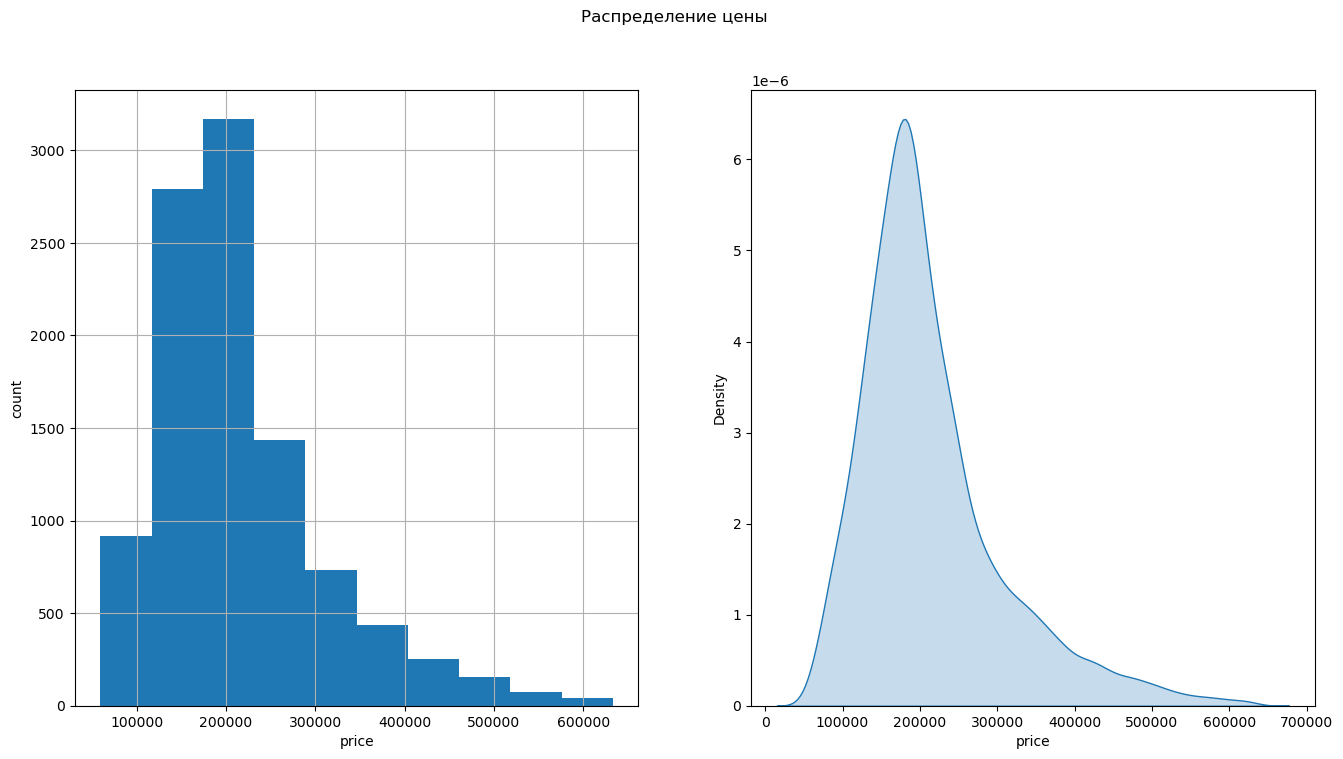

In [10]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
train_df['Price'].hist()
plt.ylabel('count')
plt.xlabel('price')

plt.subplot(122)
sns.kdeplot(train_df['Price'], shade=True, legend=False)
plt.xlabel('price')

plt.suptitle('Распределение цены')
plt.show()

Количественные переменные

In [11]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Номинотивные переменные

In [12]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [13]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
207      1
117      1
174      1
205      1
209      1
Name: DistrictId, Length: 205, dtype: int64

In [14]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [15]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [16]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### Обработка выбросов

Rooms

In [17]:
rooms_med = train_df['Rooms'].median()
train_df.loc[train_df['Rooms'].isin([0, 10, 19]), 'Rooms'] = rooms_med

In [18]:
train_df['Rooms'].value_counts()

2.0    3891
1.0    3705
3.0    2235
4.0     150
5.0      18
6.0       1
Name: Rooms, dtype: int64

Работаем с выбросами признаков "LifeSquare" и "KitchenSquare"

In [19]:
lifesq_med = train_df['LifeSquare'].median()
kitchsq_med = train_df['KitchenSquare'].median()
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] = lifesq_med
train_df.loc[train_df['LifeSquare'] < 10, 'LifeSquare'] = lifesq_med
train_df.loc[train_df['LifeSquare'] > 400, 'LifeSquare'] = lifesq_med
train_df.loc[train_df['KitchenSquare'] < 5, 'KitchenSquare'] = kitchsq_med
train_df.loc[train_df['KitchenSquare'] > 80, 'KitchenSquare'] = kitchsq_med

HouseFloor, Floor

In [20]:
hfloor_med = train_df['HouseFloor'].median()
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = hfloor_med

In [21]:
ind = train_df[train_df['Floor'] > train_df['HouseFloor']].index
train_df.loc[ind, 'Floor'] = train_df.loc[ind, 'HouseFloor']

HouseYear

In [22]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

Работаем с выбросами признака "Square"

In [23]:
square_med = train_df['Square'].median()
train_df.loc[train_df['Square'] < 16, 'Square'] = square_med
train_df.loc[train_df['Square'] > 400, 'Square'] = square_med

Healthcare_1

Так как в данном признаке пропусков около 50% мы его исключаем

In [24]:
train_df.drop('Healthcare_1', axis=1, inplace=True)

### Построение новых признаков

Преобразуем категориальные признаки "Ecology_2", "Ecology_3", "Shops_2" в бинарные

In [25]:
train_df['Ecology_2_bin'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3_bin'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2_bin'] = train_df['Shops_2'].replace({'A':0, 'B':1})

Вычисляем "m_2_Price" - стоимость квадратного метра общей площади

In [26]:
train_df['m_2_Price'] = train_df['Price'] / train_df['Square']

На его основе создаем новые признаки m_2_MedPriceByDistrict - медианная стоимость квадратного метра в зависимости от района и m_2_MedPriceByHouseYear - медианная стоимость квадратного метра в зависимости от возраста дома

In [27]:
m_2_MedPriceByDistrict = train_df.groupby(['DistrictId'], as_index=False).agg({'m_2_Price':'median'})\
                    .rename(columns={'m_2_Price':'m_2_MedPriceByDistrict'})
m_2_MedPriceByHouseYear = train_df.groupby(['HouseYear'], as_index=False).agg({'m_2_Price':'median'})\
                    .rename(columns={'m_2_Price':'m_2_MedPriceByHouseYear'})

Добавляем новые признаки к датасету

In [28]:
train_df = train_df.merge(m_2_MedPriceByDistrict, on=['DistrictId'], how='left')
train_df = train_df.merge(m_2_MedPriceByHouseYear, on=['HouseYear'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,m_2_Price,m_2_MedPriceByDistrict,m_2_MedPriceByHouseYear
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,0,11,B,184966.930730,1,1,1,3854.958571,4358.274853,4473.255408
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,16,B,300009.450063,1,1,1,4567.491245,4437.304072,4317.685445
2,4765,53,2.0,44.947953,29.197612,6.0,8,12.0,1968,0.049637,...,1,3,B,220925.908524,1,1,1,4915.149522,4845.919064,4429.204254
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,0,5,B,175616.227217,1,1,1,3291.591637,2949.975415,2901.326376
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,2,4,B,150226.531644,1,1,1,3788.892642,3992.031265,4367.263383


In [29]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,m_2_Price,m_2_MedPriceByDistrict,m_2_MedPriceByHouseYear
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.888800,56.228457,35.980607,7.490600,7.918200,12.95910,1984.872400,0.118858,24.687000,5352.157400,8.039200,1.319500,4.231300,214138.857399,0.990300,0.972500,0.917500,3891.739716,3927.295723,3780.144330
std,0.812096,19.058793,15.378518,3.290409,5.186386,6.44346,18.416347,0.119025,17.532614,4006.799803,23.831875,1.493601,4.806341,92872.293865,0.098015,0.163543,0.275139,1251.728243,997.479341,762.735269
min,1.000000,16.117154,10.523868,5.000000,1.000000,1.00000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,752.588644,2273.498737,2764.147132
25%,1.000000,41.800063,27.654813,6.000000,4.000000,9.00000,1974.000000,0.017647,6.000000,1564.000000,0.000000,0.000000,1.000000,153872.633942,1.000000,1.000000,1.000000,2916.973642,2938.048239,2901.326376
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.00000,1977.000000,0.075424,25.000000,5285.000000,2.000000,1.000000,3.000000,192269.644879,1.000000,1.000000,1.000000,3907.999942,4134.353749,4285.794408
75%,2.000000,65.889736,41.415441,9.000000,11.000000,17.00000,2001.000000,0.195781,36.000000,7227.000000,5.000000,2.000000,6.000000,249135.462171,1.000000,1.000000,1.000000,4690.526670,4562.026777,4409.376396
max,6.000000,275.645284,263.542020,78.000000,42.000000,117.00000,2020.000000,0.521867,74.000000,19083.000000,141.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,11854.652892,8700.768533,7823.822055


Построим Корреляционную матрицу

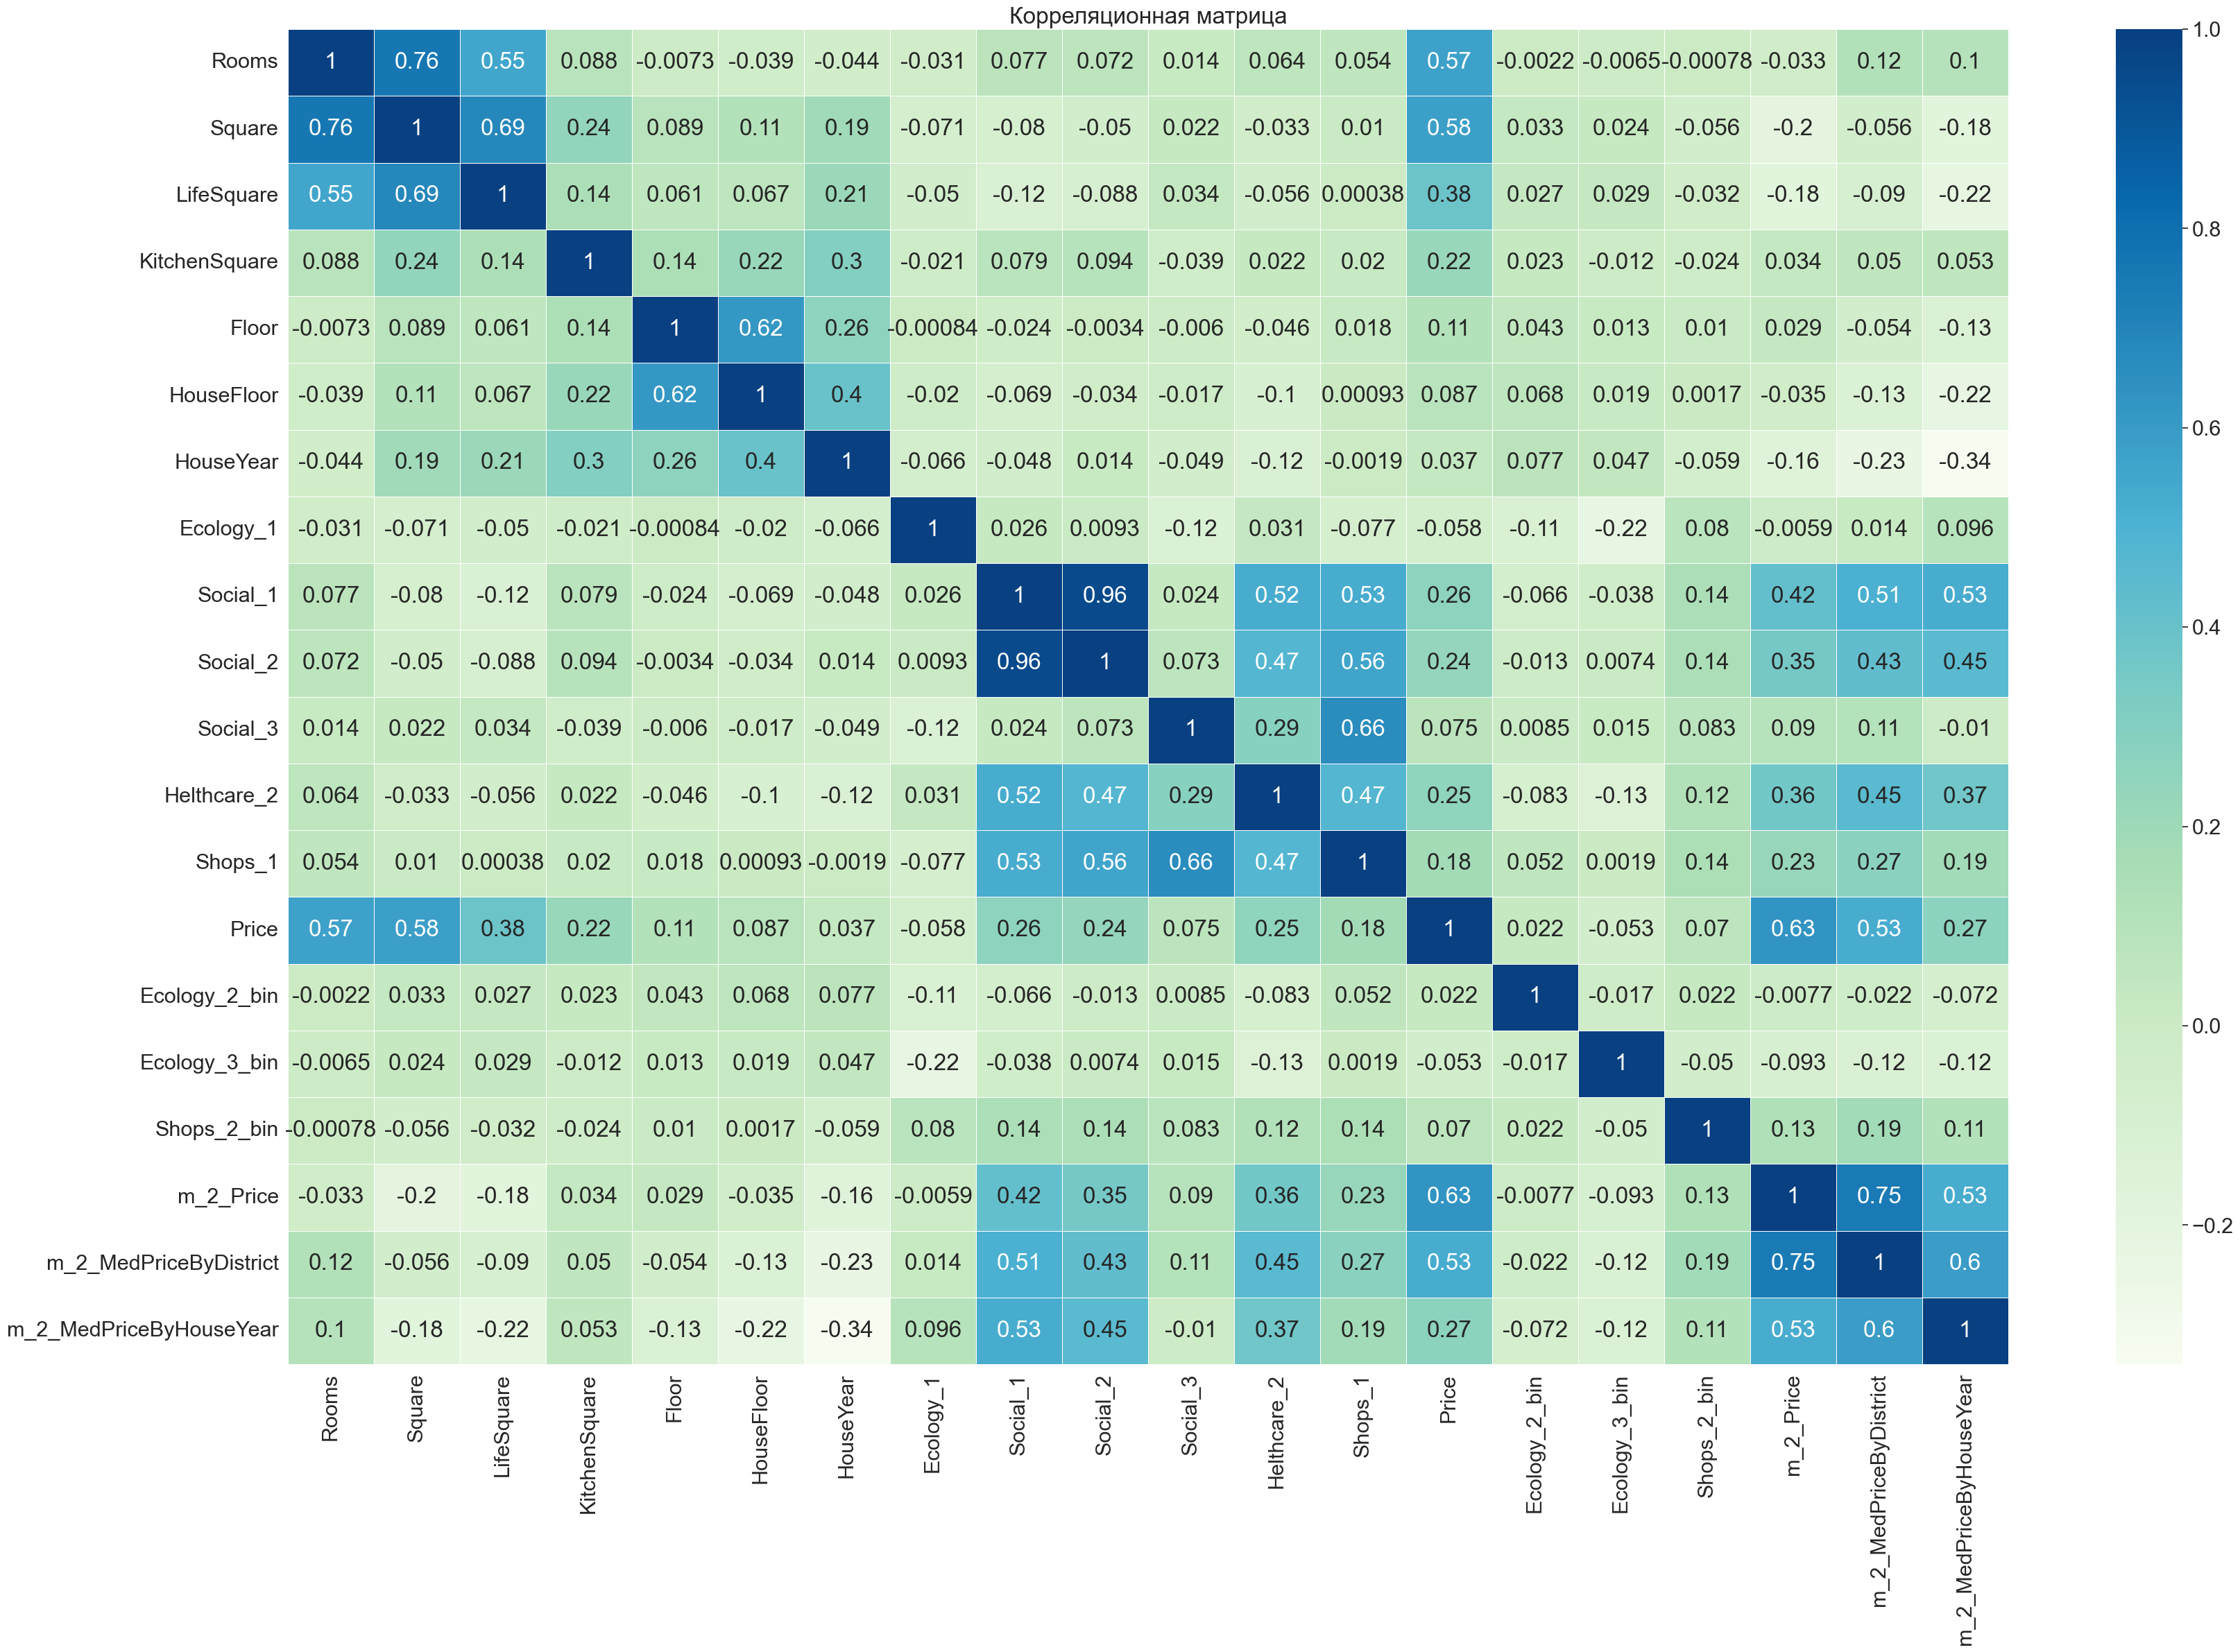

In [30]:
plt.figure(figsize = (40,25))

sns.set(font_scale=2)
sns.heatmap(train_df.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Корреляционная матрица')
plt.show()

### Отбираем признаки для модели

In [31]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 
                 'm_2_MedPriceByDistrict', 'm_2_MedPriceByHouseYear', 
                 'Ecology_1','Social_1', 'Social_3', 'Helthcare_2', 'Shops_1', 
                 'Ecology_2_bin', 'Ecology_3_bin', 'Shops_2_bin',]
target_name = 'Price'

In [32]:
df = train_df[feature_names + [target_name]]
df.head(10)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,m_2_MedPriceByDistrict,m_2_MedPriceByHouseYear,Ecology_1,Social_1,Social_3,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,Price
0,2.0,47.981561,29.442751,6.0,7,9.0,1969,4358.274853,4473.255408,0.089040,33,5,0,11,1,1,1,184966.930730
1,3.0,65.683640,40.049543,8.0,7,9.0,1978,4437.304072,4317.685445,0.000070,46,1,1,16,1,1,1,300009.450063
2,2.0,44.947953,29.197612,6.0,8,12.0,1968,4845.919064,4429.204254,0.049637,34,0,1,3,1,1,1,220925.908524
3,2.0,53.352981,52.731512,9.0,8,17.0,1977,2949.975415,2901.326376,0.437885,23,3,0,5,1,1,1,175616.227217
4,1.0,39.649192,23.776169,7.0,11,12.0,1976,3992.031265,4367.263383,0.012339,35,1,2,4,1,1,1,150226.531644
5,3.0,80.384479,46.683720,12.0,5,17.0,2011,4736.631611,3085.925983,0.309479,35,4,0,6,1,1,1,215898.447742
6,2.0,62.254114,37.160377,7.0,3,5.0,1960,5445.489427,4471.625922,0.460556,20,14,1,5,1,1,1,296021.204377
7,2.0,80.312926,32.781260,6.0,13,13.0,1977,3319.318045,2901.326376,0.075779,6,3,0,2,1,1,1,221244.156664
8,2.0,64.511437,32.781260,6.0,9,17.0,1977,3251.647396,2901.326376,0.007122,1,0,0,1,1,1,1,229102.795999
9,1.0,46.461409,18.915552,8.0,13,17.0,2014,2273.498737,2793.739365,0.075779,6,3,0,2,1,1,1,95380.220993


Масштабируем признаки

In [33]:
scaler = StandardScaler()
stand_features = scaler.fit_transform(df[feature_names])

In [34]:
df[feature_names] = pd.DataFrame(stand_features, columns=feature_names)
df.head(10)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,m_2_MedPriceByDistrict,m_2_MedPriceByHouseYear,Ecology_1,Social_1,Social_3,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,Price
0,0.136936,-0.432730,-0.425150,-0.453036,-0.177049,-0.614468,-0.861908,0.432090,0.908763,-0.250529,0.474169,-0.127533,-0.883480,1.408356,0.09897,0.16816,0.299864,184966.930730
1,1.368379,0.496131,0.264599,0.154821,-0.177049,-0.614468,-0.373187,0.511323,0.704790,-0.998053,1.215681,-0.295384,-0.213923,2.448700,0.09897,0.16816,0.299864,300009.450063
2,0.136936,-0.591909,-0.441092,-0.453036,0.015773,-0.148856,-0.916210,0.920991,0.851006,-0.581588,0.531208,-0.337347,-0.213923,-0.256195,0.09897,0.16816,0.299864,220925.908524
3,0.136936,-0.150882,1.089295,0.458750,0.015773,0.627163,-0.427489,-0.979839,-1.152250,2.680470,-0.096225,-0.211458,-0.883480,0.159943,0.09897,0.16816,0.299864,175616.227217
4,-1.094506,-0.869945,-0.793643,-0.149107,0.594239,-0.148856,-0.481792,0.064902,0.769793,-0.894969,0.588247,-0.295384,0.455633,-0.048126,0.09897,0.16816,0.299864,150226.531644
5,1.368379,1.267511,0.696013,1.370536,-0.562694,0.627163,1.418789,0.811422,-0.910215,1.601602,0.588247,-0.169496,-0.883480,0.368011,0.09897,0.16816,0.299864,215898.447742
6,0.136936,0.316177,0.076719,-0.149107,-0.948338,-1.235283,-1.350629,1.522106,0.906627,2.870953,-0.267344,0.250131,-0.213923,0.159943,0.09897,0.16816,0.299864,296021.204377
7,0.136936,1.263756,-0.208050,-0.453036,0.979884,0.006348,-0.427489,-0.609545,-1.152250,-0.361948,-1.065895,-0.211458,-0.883480,-0.464264,0.09897,0.16816,0.299864,221244.156664
8,0.136936,0.434623,-0.208050,-0.453036,0.208595,0.627163,-0.427489,-0.677390,-1.152250,-0.938799,-1.351093,-0.337347,-0.883480,-0.672333,0.09897,0.16816,0.299864,229102.795999
9,-1.094506,-0.512495,-1.109724,0.154821,0.979884,0.627163,1.581696,-1.658059,-1.293311,-0.361948,-1.065895,-0.211458,-0.883480,-0.464264,0.09897,0.16816,0.299864,95380.220993


### Разбиение на train и test

In [35]:
X = df[feature_names]
y = df[target_name]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.67, shuffle=True, random_state=42)

### Построение модели

Обучение

In [36]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(criterion='mse', random_state=21)

Оценка модели

Train R2:	0.967
Test R2:	0.739


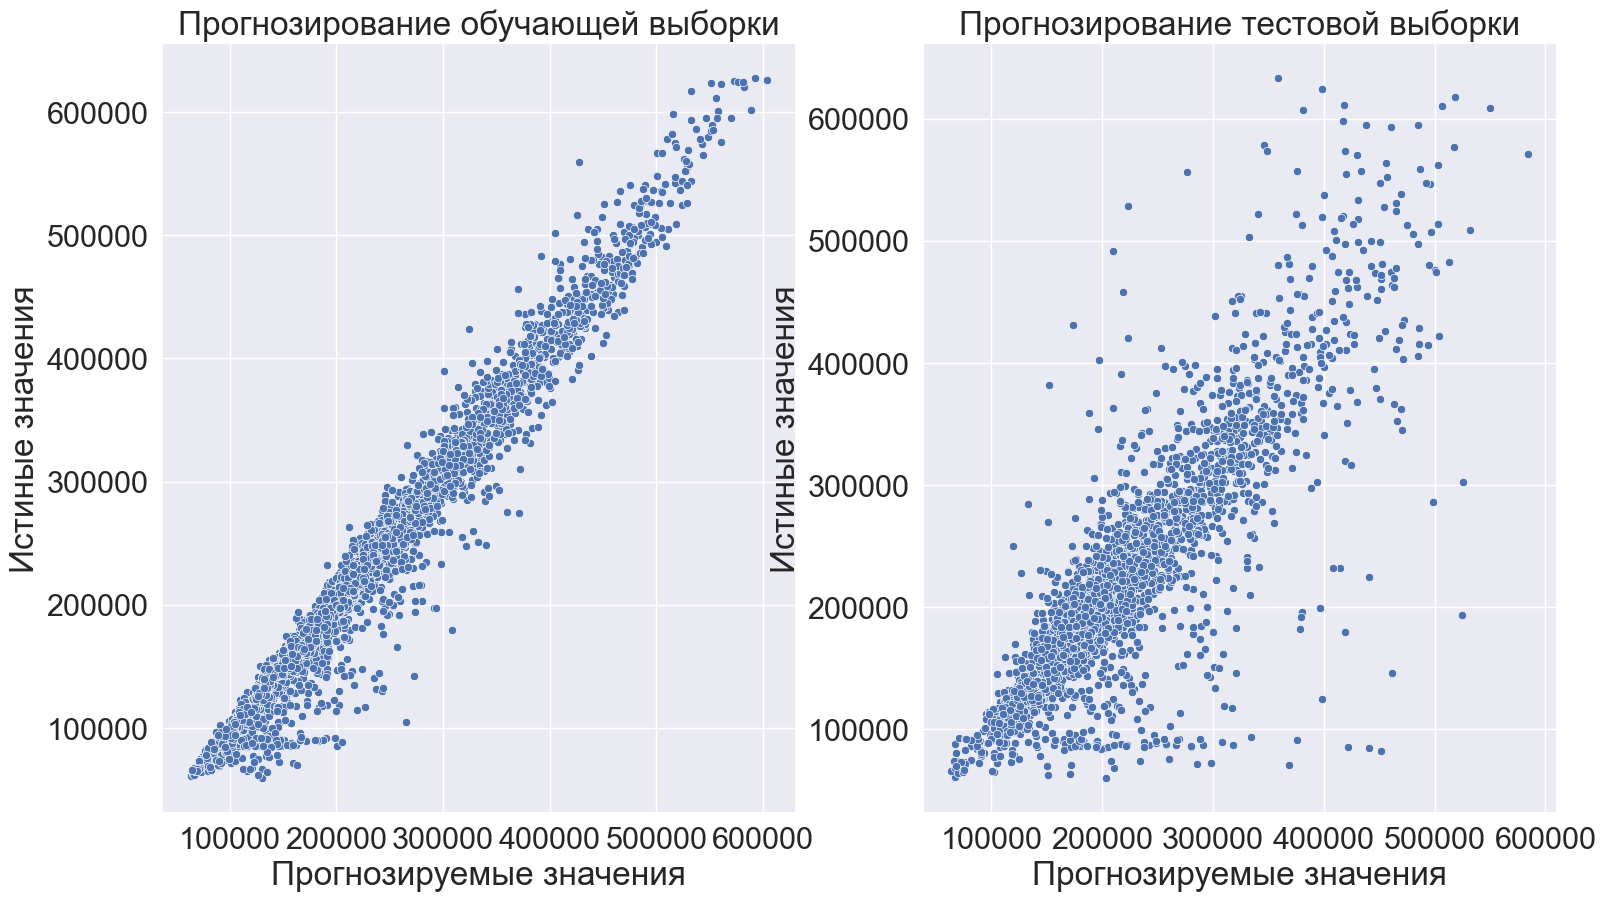

In [37]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

### Кросс-валидация

In [38]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.76895371, 0.71342513, 0.75548216])

In [39]:
cv_score.mean()

0.7459536657074862

### Важность признаков

In [40]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.426899
7,m_2_MedPriceByDistrict,0.340420
8,m_2_MedPriceByHouseYear,0.034651
0,Rooms,0.025283
2,LifeSquare,0.024171
10,Social_1,0.023764
6,HouseYear,0.021233
4,Floor,0.020808
9,Ecology_1,0.018885
5,HouseFloor,0.016124


### Прогнозирование на тестовом датасете

In [41]:
test_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A


Смотрим размер датасета

In [42]:
test_df.shape

(5000, 19)

Смотрим информацию датасета

In [43]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

Приводим Id и DistrictId к строковому типу

In [44]:
test_df['Id'] = train_df['Id'].astype(str)
test_df['DistrictId'] = train_df['DistrictId'].astype(str)

Смотрим количественные переменные

In [45]:
test_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


### Добовляем новые фичи

In [46]:
test_df['Ecology_2'].value_counts()
test_df['Ecology_3'].value_counts()
test_df['Shops_2'].value_counts()

B    4588
A     412
Name: Shops_2, dtype: int64

In [47]:
test_df['Ecology_2_bin'] = test_df['Ecology_2'].replace({'A':0, 'B':1})
test_df['Ecology_3_bin'] = test_df['Ecology_3'].replace({'A':0, 'B':1})
test_df['Shops_2_bin'] = test_df['Shops_2'].replace({'A':0, 'B':1})

In [48]:
test_df = test_df.merge(m_2_MedPriceByDistrict, on=['DistrictId'], how='left')
test_df = test_df.merge(m_2_MedPriceByHouseYear, on=['HouseYear'], how='left')

### Работа с пропусками и выбросами

In [49]:
test_df = test_df.drop('Healthcare_1', axis=1)

In [50]:
test_df.loc[test_df['Rooms'].isin([0, 17]), 'Rooms'] = rooms_med

In [51]:
test_df.loc[test_df['LifeSquare'].isnull(), 'LifeSquare'] = lifesq_med
test_df.loc[test_df['LifeSquare'] < 10, 'LifeSquare'] = lifesq_med
test_df.loc[test_df['LifeSquare'] > 200, 'LifeSquare'] = lifesq_med
test_df.loc[test_df['KitchenSquare'] < 5, 'KitchenSquare'] = kitchsq_med
test_df.loc[test_df['KitchenSquare'] > 80, 'KitchenSquare'] = kitchsq_med

In [52]:
test_df.loc[test_df['Square'] < 16, 'Square'] = square_med
test_df.loc[test_df['Square'] > 400, 'Square'] = square_med

In [53]:
test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor'] = hfloor_med
ind = test_df[test_df['Floor'] > test_df['HouseFloor']].index
test_df.loc[ind, 'Floor'] = test_df.loc[ind, 'HouseFloor']

In [54]:
test_df.loc[test_df['m_2_MedPriceByDistrict'].isnull(), 'm_2_MedPriceByDistrict'] =\
                    m_2_MedPriceByDistrict['m_2_MedPriceByDistrict'].median()
test_df.loc[(test_df['m_2_MedPriceByHouseYear'].isnull()) & (test_df['HouseYear'] < 1950), 
                     'm_2_MedPriceByHouseYear'] =\
                      m_2_MedPriceByHouseYear.loc[m_2_MedPriceByHouseYear['HouseYear'] < 1950,
                                                  'm_2_MedPriceByHouseYear'].median()
test_df.loc[(test_df['m_2_MedPriceByHouseYear'].isnull()) & (test_df['HouseYear'] >= 1990), 
                     'm_2_MedPriceByHouseYear'] =\
                      m_2_MedPriceByHouseYear.loc[m_2_MedPriceByHouseYear['HouseYear'] >= 1990,
                                                  'm_2_MedPriceByHouseYear'].median()
test_df.loc[(test_df['m_2_MedPriceByHouseYear'].isnull()) & (test_df['HouseYear'] >= 1950) &\
                    (test_df['HouseYear'] < 1990), 'm_2_MedPriceByHouseYear'] =\
                      m_2_MedPriceByHouseYear.loc[(m_2_MedPriceByHouseYear['HouseYear'] >= 1950) & \
                                                  (m_2_MedPriceByHouseYear['HouseYear'] < 1990),
                                                  'm_2_MedPriceByHouseYear'].median()

Масштабируем признаки

In [55]:
stand_features = scaler.fit_transform(test_df[feature_names])
test_df[feature_names] = pd.DataFrame(stand_features, columns=feature_names)

Предсказываем цены для тестового датасета

In [56]:
X_test = test_df[feature_names]

In [57]:
y_test_preds = rf_model.predict(X_test)

In [58]:
y_test_preds

array([190887.05659407, 216744.49758408, 191671.80966927, ...,
       320690.69966008, 404542.2896956 , 151321.51648665])

Сохраняем результаты

In [59]:
test_df['Price'] = y_test_preds
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,m_2_MedPriceByDistrict,m_2_MedPriceByHouseYear,Price
0,14038,35,0.113827,-0.351446,-0.177804,-0.469265,-0.384893,0.163681,-0.667299,1.585280,...,-0.304366,-0.891612,-0.888194,B,0.098453,0.175258,0.299666,0.433999,0.650315,190887.056594
1,15053,41,0.113827,0.671088,-0.222109,-0.469265,-1.321830,-1.846763,-0.398066,-0.367283,...,-0.220549,-0.891612,-0.469511,B,0.098453,0.175258,0.299666,0.512976,-1.167186,216744.497584
2,4765,53,-1.120741,-0.212649,-1.366792,1.505478,-1.134442,-1.228165,-4.059632,-0.998468,...,3.299785,2.487242,0.158513,B,0.098453,0.175258,0.299666,0.921322,2.275193,191671.809669
3,5809,58,0.113827,0.870705,1.080786,0.518107,2.613303,1.400877,1.217331,-0.149940,...,-0.220549,1.135700,-0.260169,B,0.098453,0.175258,0.299666,-0.973373,0.802375,241386.458458
4,10783,99,-1.120741,-0.475725,0.499144,-0.469265,1.676366,0.627630,1.755796,-0.397445,...,-0.304366,-0.891612,-0.888194,A,0.098453,0.175258,-3.337053,0.067997,-0.971467,153681.258038


In [60]:
test_df.to_csv(PREDICTIONS_PATH, columns=['Id', 'Price'], index=False, encoding='utf-8')